# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-2.059921,False,-5.026718
1,0.330154,False,1.245369
2,-2.016059,False,-3.782159
3,-0.917518,False,-1.148860
4,-0.460827,True,4.071410
...,...,...,...
995,-0.438094,False,1.280133
996,-2.564824,False,-6.593288
997,-1.131360,False,-2.425343
998,0.078520,True,4.477583


<AxesSubplot:xlabel='v0'>

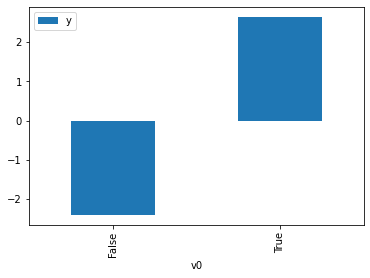

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

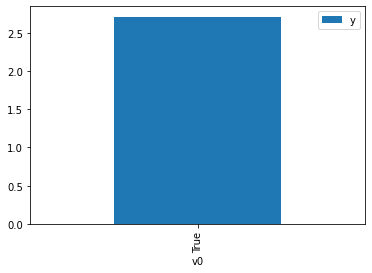

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.851571,False,-3.234982,0.809244,1.235721
1,-1.435272,False,-3.721958,0.921187,1.085556
2,-1.179797,False,-3.603810,0.882364,1.133320
3,-1.703952,False,-5.023180,0.949073,1.053659
4,-1.275373,False,-3.069588,0.898526,1.112934
...,...,...,...,...,...
995,-1.542162,False,-6.069342,0.933651,1.071063
996,-0.293043,False,-0.759275,0.616644,1.621681
997,-0.315967,False,-1.334592,0.626009,1.597421
998,0.126174,False,-1.287428,0.437194,2.287317


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.381571,True,3.005139,0.347728,2.875809
1,0.747031,True,5.108931,0.790933,1.264330
2,-1.145192,True,0.360264,0.124018,8.063357
3,-0.105434,True,4.943102,0.462674,2.161349
4,-0.961432,True,1.499297,0.163030,6.133854
...,...,...,...,...,...
995,-0.306174,True,3.241492,0.377980,2.645640
996,-2.280853,True,-0.565131,0.019326,51.743125
997,-0.481154,True,5.067285,0.309609,3.229877
998,0.823388,True,8.120757,0.812012,1.231509


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.949
Model:                            OLS   Adj. R-squared (uncentered):              0.949
Method:                 Least Squares   F-statistic:                              9350.
Date:                Wed, 03 Aug 2022   Prob (F-statistic):                        0.00
Time:                        13:59:37   Log-Likelihood:                         -1412.8
No. Observations:                1000   AIC:                                      2830.
Df Residuals:                     998   BIC:                                      2839.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.4814      0.023    105.717      0.000       2.435       2.527
x2             4.9367      0.059     83.433      0.000       4.821       5.053
==============================================================================
Omnibus:                        3.376   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.185   Jarque-Bera (JB):                3.245
Skew:                           0.134   Prob(JB):                        0.197
Kurtosis:                       3.080   Cond. No.                         2.52
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""